# TP6 - Clasificador de imágenes con red convolucional

Guarda una copia de este cuaderno en tu Google Drive para poder editarla y ejecutarla.

El propio cuaderno será tu informe del trabajo. Puedes añadir tantas secciones de código y de texto como consideres necesario para resolver todos los ejercicios propuestos y analizar los resultados obtenidos. Una vez hayas terminado, descarga el notebook en formato ipynb y súbelo a Moodle en la tarea habilitada para el TP6 con el nombre NIP_TP6_CNN.ipynb

Es **obligatorio** que se **guarden los resultados de la evaluación** de cada celda de código (para no tener que volver a ejecutarlas). Por defecto los notebooks estan configurados así (Edit→Notebook Settings → NUNCA actives: Omit code cell output when saving this notebook)

El Notebook incluye código de ejemplo para definir y entrenar una red convolucional con el dataset MNIST. Recuerda que **esta parte del trabajo se debe realizar con el dataset CIFAR 10**.

Imports necesarios para ejecutar el trabajo

In [ ]:
import time
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()

    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()

Carga del dataset MNIST

Importante observar como la organización de los datos es diferente que en el caso del perceptrón para poder aplicar bien las convoluciones

In [ ]:
# LOAD MNIST
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test,  num_classes)

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
# Definicion de la red convolucional
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

## Preguntas a responder de la celda anterior:

### 1.    Incluye un dibujo de la arquitectura de la red programada en la celda anterior.


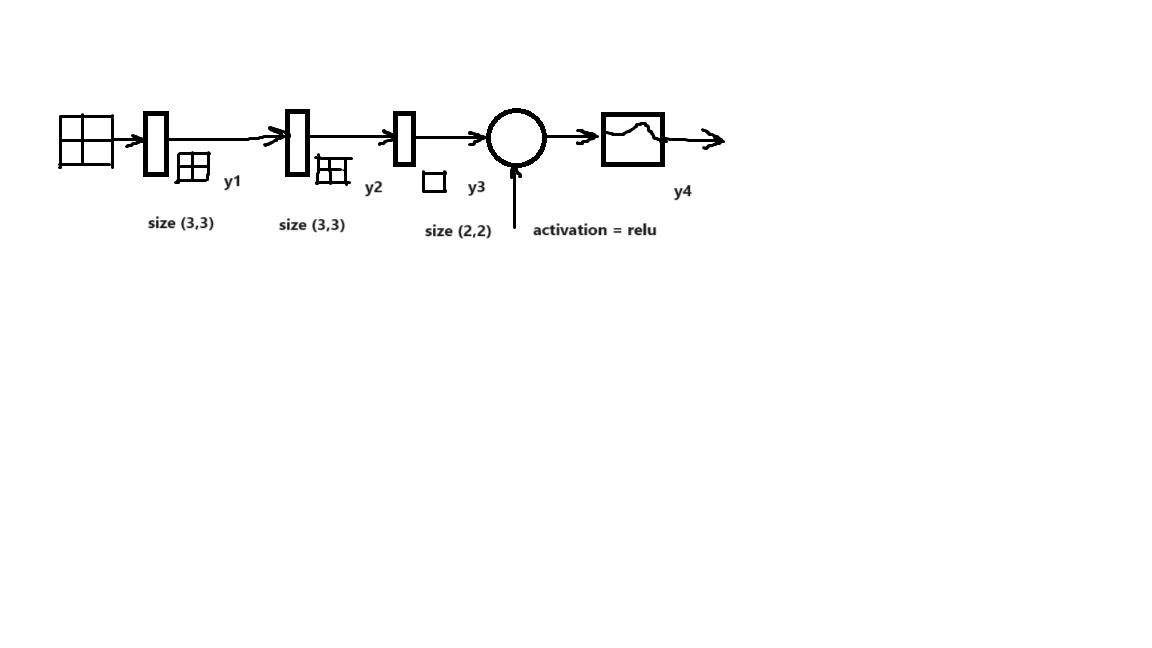

### 2.    Explica brevemente qué hace cada capa de la red.

La capa de convolución en 2 dimensiones (Conv2D) es la base de las CNN. Sirve para aplicar filtros a la entrada, que son datos en 2D como imágenes, de forma que se pueda extraer información, patrones o características de los datos.

La capa MaxPooling2D se utiliza para reducir el tamaño de la salida, dejando así solo las características más importantes. Así se reduce la matriz obtenida en la capa Conv2D.

La capa Flatten reduce la salida de la capa MaxPooling2D a una sola dimensión, para poder transmitir el vector unitario a la capa Dense.

## Entrenamiento

Epoch 1/12
469/469 [==============================] - 11s 10ms/step - loss: 0.2477 - accuracy: 0.9242
Epoch 2/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0879 - accuracy: 0.9741
Epoch 3/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0631 - accuracy: 0.9806
Epoch 4/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0549 - accuracy: 0.9832
Epoch 5/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0436 - accuracy: 0.9864
Epoch 6/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0395 - accuracy: 0.9874
Epoch 7/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0357 - accuracy: 0.9886
Epoch 8/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0299 - accuracy: 0.9901
Epoch 9/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0300 - accuracy: 0.9901
Epoch 10/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0256 - accuracy: 0.99

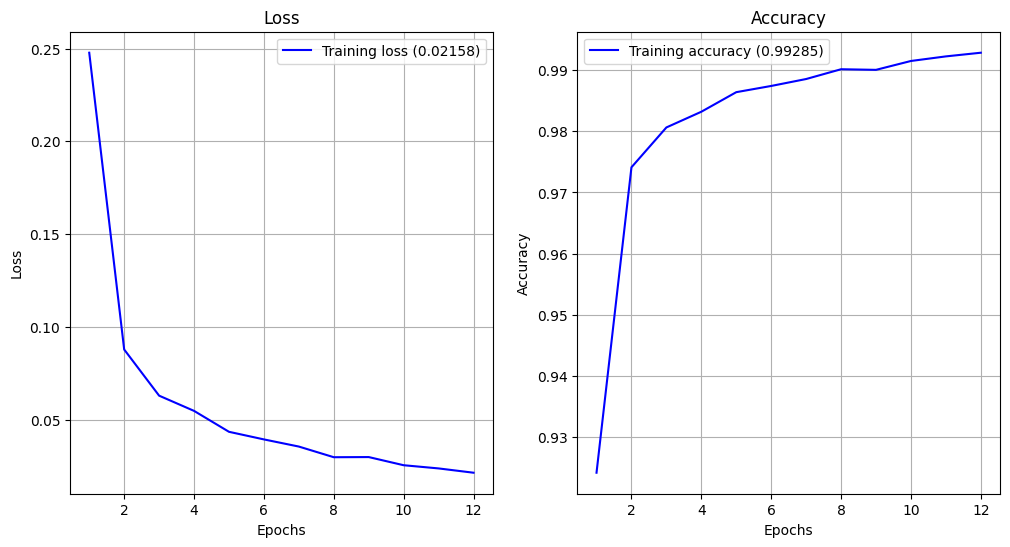

In [ ]:
# Ajuste de los parámetros de la red
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

## Preguntas a responder de la celda anterior

¿Qué diferencias observas en el entrenamiento y en los resultados en comparación con las redes diseñadas en el otro Notebook?

Se observa que los resultados son mejores comparados con la mejor red conseguida en el Notebook anterior: el test accuracy en esta red convolucional es de un 99.18%, mayor que el 98% resultante del perceptrón multicapa.
Otra diferencia es que el número de epochs en la práctica 6 era de 20 y ahora es de 12. Además, en este Notebook no se toma solo el 10% de los datos de entrenamiento (x_train) para la evaluación.  

TAREAS A REALIZAR:

1. Modifica la carga de datos, y la configuración inicial de la red si lo ves necesario,
para que cargue/utilice el dataset CIFAR10 en lugar de MNIST. Puedes pasar a
blanco y negro las imágenes, o hacer que la red trabaje con imagenes en color (n x
m x 3), y siempre, normalizar los valores (atributos con valores entre 0 y 1).

In [ ]:
# cargar datos CIFAR10
batch_size = 128
num_classes = 10
epochs = 12

#dimensiones de imagen
img_filas, img_cols = 32, 32

#datos separados en entrenamiento y evaluación
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

if K.image_data_format() == 'channels_first' :
  x_train = x_train.reshape(x_train.shape[0], 3, img_filas, img_cols)
  x_test = x_test.reshape(x_test.shape[0], 3, img_filas, img_cols)
  input_shape = (3, img_filas, img_cols)
else:
  x_train = x_train.reshape(x_train.shape[0], img_filas, img_cols, 3)
  x_test = x_test.reshape(x_test.shape[0], img_filas, img_cols, 3)
  input_shape = (img_filas, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

#convertir vectores de clase a matrices de clases binarias
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


x_train shape:  (50000, 32, 32, 3)
50000 train samples
10000 test samples


2.   Entrena un perceptrón multi-capa y evalúa los resultados que obtiene para CIFAR10. Compara estos resultados con los obtenidos en el dataset anterior (MNIST)

In [ ]:
#función para parar cuando se ha llegado al límite de mejora del error en los datos de evaluación
earlystop = EarlyStopping(monitor = 'val_loss', patience=5, verbose=1, mode='auto')

#perceptrón con dos capas ocultas
model = Sequential()
model.add(Flatten(input_shape = input_shape))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(256, activation = 'sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               786688    
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                2570      
                                                                 
Total params: 855050 (3.26 MB)
Trainable params: 855050 (3.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
t0 = time.perf_counter()
history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.1, callbacks=[earlystop], verbose=True)
train_time = time.perf_counter() - t0
print('%s %.3f%s' % ('Training time: ', train_time, 's'))
plot_history(history)

#Evaluar la red
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print('%s %2.2f%s' % ('Accuracy train: ', 100*train_score[1], '%'))
print('%s %2.2f%s' % ('Accuracy test: ', 100*test_score[1], '%'))



Los resultados obtenidos son peores que para el dataset MNIST en la práctica 6 (48,72% de accuracy test, mucho menor que el 98,07% obtenido en el Notebook anterior)

Esto ocurre porque CIFAR10 presenta imágenes a color más grandes (32x32), y todas las imágenes cambian mucho. Es un conjunto de datos más complicado, así que se concluye que utilizar solo un MLP no es buena idea

3. Entrena una red convolucional y evalúa los resultados que obtiene con CIFAR10. Compara estos resultados con los obtenidos para el perceptrón.

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Epoch 1/12
391/391 [==============================] - 9s 16ms/step - loss: 1.7449 - accuracy: 0.3472
Epoch 2/12
391/391 [==============================] - 6s 15ms/step - loss: 1.2961 - accuracy: 0.5363
Epoch 3/12
391/391 [==============================] - 6s 14ms/step - loss: 1.0908 - accuracy: 0.6159
Epoch 4/12
391/391 [==============================] - 6s 15ms/step - loss: 0.9814 - accuracy: 0.6560
Epoch 5/12
391/391 [==============================] - 6s 14ms/step - loss: 0.8892 - accuracy: 0.6919
Epoch 6/12
391/391 [==============================] - 6s 15ms/step - loss: 0.8271 - accuracy: 0.7134
Epoch 7/12
391/391 [==============================] - 6s 14ms/step - loss: 0.7899 - accuracy: 0.7285
Epoch 8/12
391/391 [==============================] - 6s 15ms/step - loss: 0.7450 - accuracy: 0.7436
Epoch 9/12
391/391 [==============================] - 6s 15ms/step - loss: 0.7045 - accuracy: 0.7570
Epoch 10/12
391/391 [==============================] - 6s 15ms/step - loss: 0.6790 - accura

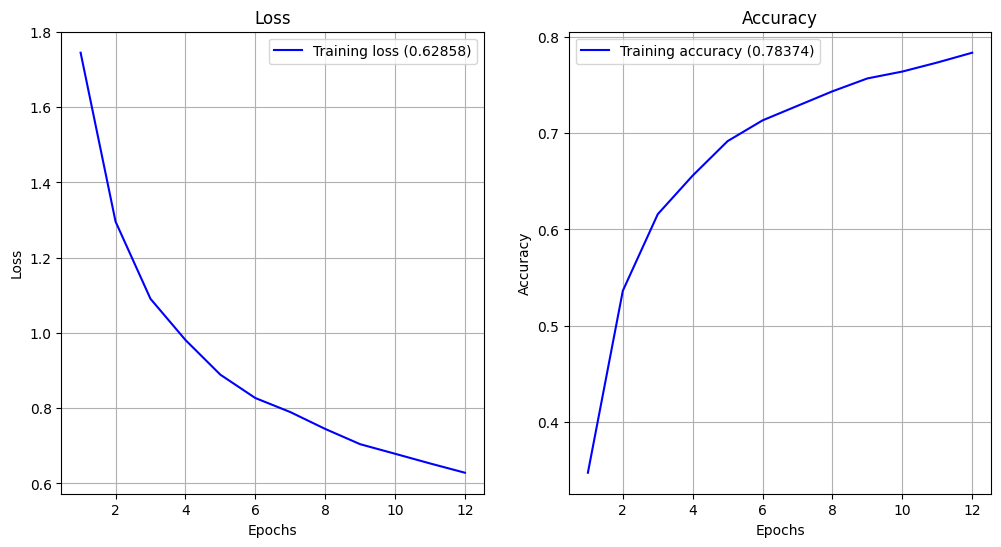

In [ ]:
#Ajustar parámetos
history = model.fit(x_train, y_train,
batch_size=batch_size,
epochs=epochs,
verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)


Resulta en un 78% de accuracy test, mucho mayor que el 48.77% obtenido del MLP. Las redes convolucionales son mejores que MLP clasificando imágenes y son especialmente buenas en espacios multidimensionales. Además, CIFAR10 es un conjunto de datos más fuerte que MNIST.

El notebook que entregues deberá incluir:

1.   Modifica la carga de datos, y la configuración inicial de la red si lo ves necesario, para que cargue/utilice el dataset CIFAR10 en lugar de MNIST. Puedes pasar a blanco y negro las imágenes, o hacer que la red trabaje con imagenes en color (n x m x 3), y siempre, normalizar los valores (atributos con valores entre 0 y 1).
2.   Entrena un perceptrón multi-capa y evalúa los resultados que obtiene para CIFAR10. Compara estos resultados con los obtenidos en el dataset anterior (MNIST)
3.   Entrena una red convolucional y evalúa los resultados que obtiene con CIFAR10. Compara estos resultados con los obtenidos para el perceptrón.
4.   Opcional: Repite el último paso, entrenar la red convolucional, utilizando el dataset CIFAR 100, con 100 clases diferentes. En este caso, recuerda asegurarte que el Colab está utilizando una configuración con GPU.